# Ciclope example 02 - from CT image to tetrahedra FE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 12.10.2021 <br />

Data courtesy from:
### Kaya et al. (2019), Foams of Gray Cast Iron as Efficient Energy Absorption Structures: A Feasibility Study. <br /> Adv. Eng. Mater., 21: 1900080. https://doi.org/10.1002/adem.201900080

For info on the solver see the Calculix homepage:
http://www.calculix.de/

![](test_data/example_02/IMG_20201121_225702.jpg)

For info on the solver see the [Calculix homepage](http://www.calculix.de/)

## Configuration

In [82]:
import os
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
import ciclope

matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [83]:
%%html
<style>
table {float:left}
</style>

#### Inputs and parameters definition

In [84]:
input_file = '/home/gianthk/Data/TOMCAT/Kaya/B_matrix_01_/rec_8bit_0_rescale_025/B_matrix_01_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Beamline|TOMCAT@SLS|
|Sample|Sintered steel foam strut from [Kaya_2016](10.1016/j.matdes.2016.05.069)|
|Energy|34 keV|
|Camera|PCO.edge5|
|Optics|4x|
|Voxel size|1.625 micron|
|Preliminary operations|downsampled (5X; quadratic interpolation)|

In [85]:
# Read 3D data
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*1.625e-3*5 # [mm]

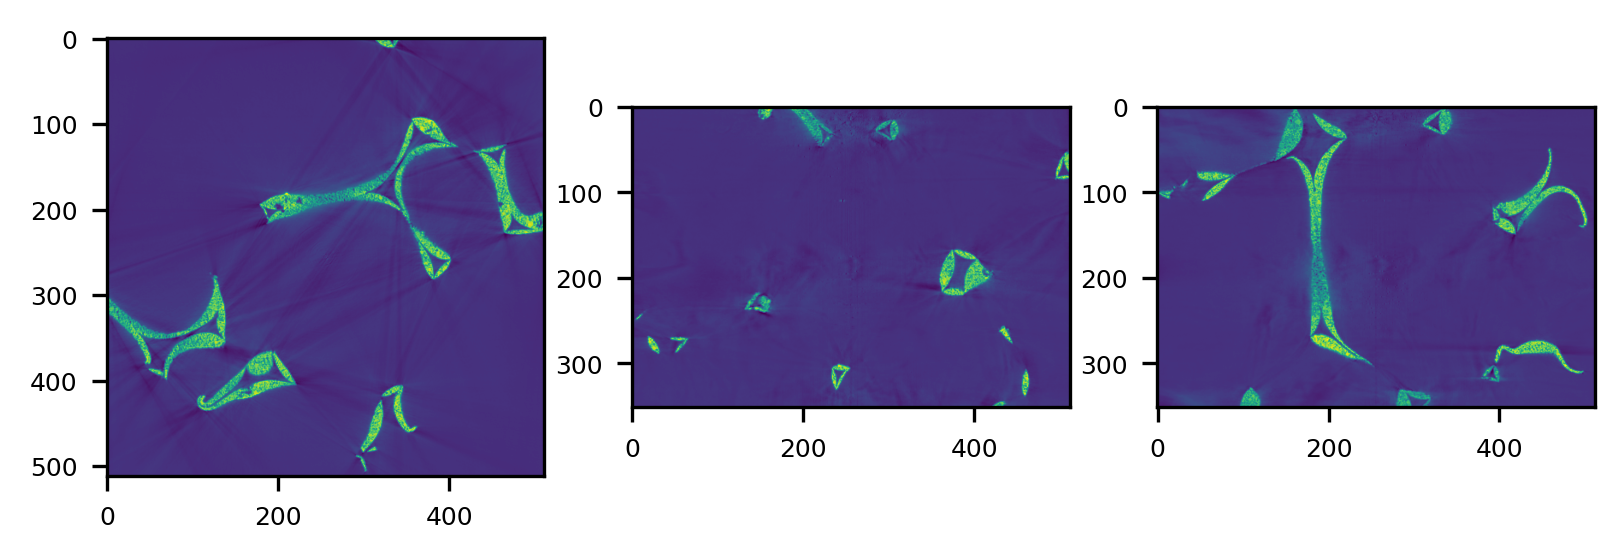

In [86]:
# Inspect dataset
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [41]:
import itk
from itkwidgets import view
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

In [ ]:
# launch itk viewer
viewer

## Pre-processing
### Gaussian smooth (optional)

In [8]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (optional)

In [48]:
resampling = 1.2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

In [ ]:
# Inspect dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding

In [87]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 90


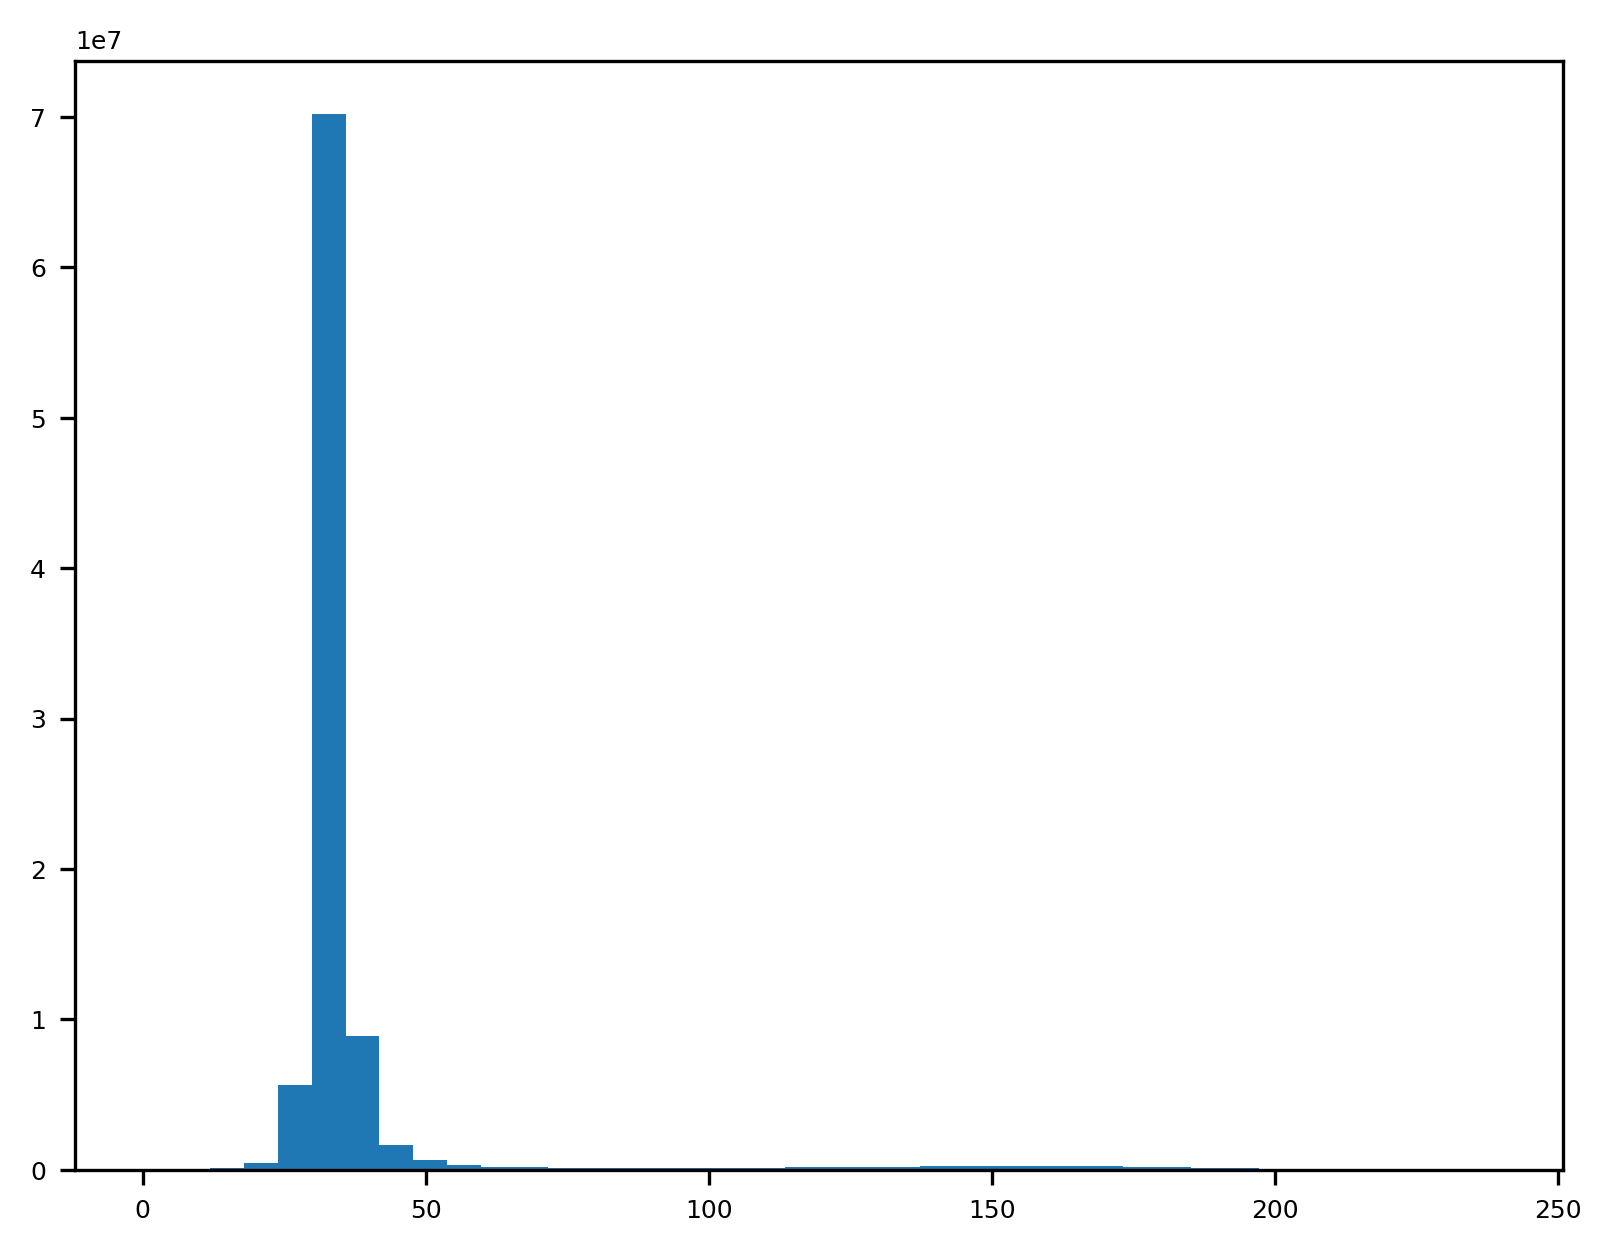

In [11]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

In [88]:
# apply the threshold
BW = data_3D > T
# BW = data_3D > 142

### Morphological close of binary image

In [89]:
BW = morphology.closing(BW, morphology.cube(5))

### Detect largest isolated cluster of voxels

In [90]:
# label the BW image
# [labels, n_labels] = measure.label(BW, None, True)
[labels, n_labels] = measure.label(BW, None, True, 1) # 1 connectivity hop

Inspect the labels with [napari](https://napari.org/)

In [ ]:
import napari
viewer = napari.view_image(labels)

In [91]:
# count occurrences of each label label
occurrences = np.bincount(labels.reshape(labels.size))

In [92]:
# find largest unconnected label
largest_label_id = occurrences[1:].argmax()+1
L = labels == largest_label_id

In [30]:
# you can use the function contained in ciclope
# L = ciclope.remove_unconnected(BW)

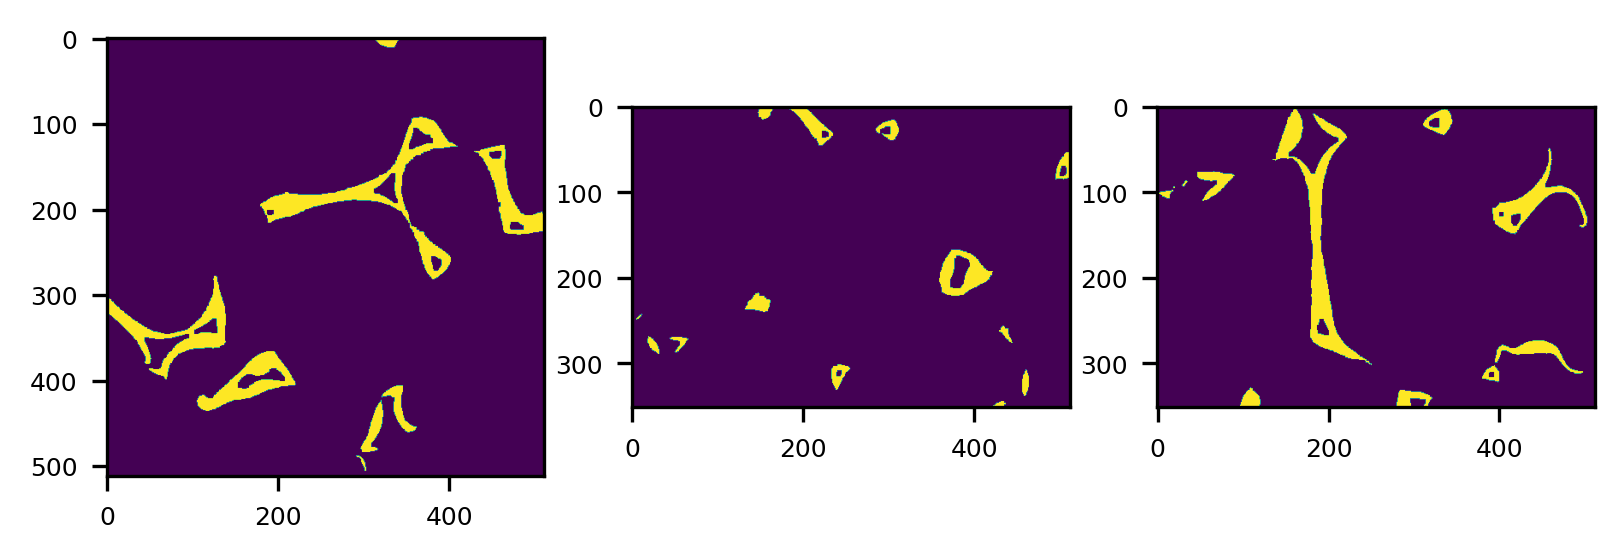

In [93]:
# Inspect dataset
# plot_midplanes(np.bitwise_xor(L, BW))
plot_midplanes(L)
plt.show()

## Meshes for visualization
### Create triangles mesh of the outer model shell (too expensive)

In [32]:
# vertices, triangles = ciclope.shell_mesh(L, method='pymcubes')

Write VTK mesh with [meshio](https://github.com/nschloe/meshio)

In [33]:
# meshio.write_points_cells("pippo_shell.vtk", vertices.tolist(), [("triangle", triangles.tolist())])

### Create tetrahedra mesh
Volume meshing using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [36]:
filename_mesh_out = '/home/gianthk/PycharmProjects/CT2FE/test_data/steel_foam/B_matrix_mesh.vtk'

In [74]:
import pygalmesh
mesh = pygalmesh.generate_from_array(np.transpose(L, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=1.2*min(vs), max_cell_circumradius=5*1.2*min(vs))

Alternatively use the method `ciclope.cgal_mesh`

In [95]:
mesh = ciclope.cgal_mesh(L, vs, 'tetra', 1.2*min(vs), 5*1.2*min(vs))

INFO:root:Removing triangle cells.


In [96]:
mesh.write(filename_mesh_out)

Visualize the mesh with itkwidgtes

In [97]:
import vtk
import itk
from itkwidgets import view

In [98]:
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName(filename_mesh_out)
reader.Update()
grid = reader.GetOutput()

In [ ]:
view(geometries=grid)

## Write Abaqus input FE files
### Generate tetrahedra-FE model with constant material properties
The method `ciclope.mesh2tetrafe` assumes that the material property definition is contained in the FE analysis `.INP` template file.

In [100]:
input_template = "input_templates/tmp_example02_tens_static_steel.inp"

In [101]:
filename_out = '/home/gianthk/PycharmProjects/CT2FE/test_data/steel_foam/B_matrix_tetraFE.inp'

In [102]:
ciclope.mesh2tetrafe(mesh, input_template, filename_out, keywords=['NSET', 'ELSET'])

INFO:root:Converting mesh with fields:

INFO:root:{'points': array([[ 1.0637777e-01,  2.7099030e+00,  1.2464654e+00],
       [ 3.1638098e+00,  2.4738045e+00,  8.2634044e-01],
       [-2.8007149e-04,  2.4925890e+00,  1.6835400e+00],
       ...,
       [ 1.7855428e+00,  3.3190203e+00,  1.1995814e+00],
       [ 6.9351017e-01,  3.2858081e+00,  2.6503036e+00],
       [ 2.7904041e+00,  2.9363434e+00,  2.7100861e+00]], dtype=float32), 'cells': [<meshio CellBlock, type: tetra, num cells: 122964>], 'point_data': {'medit:ref': array([1, 1, 1, ..., 1, 1, 1])}, 'cell_data': {'medit:ref': array([1, 1, 1, ..., 1, 1, 1])}, 'field_data': {}, 'point_sets': {}, 'cell_sets': {}, 'gmsh_periodic': None, 'info': None}
INFO:root:Reading Abaqus template file input_templates/tmp_example02_tens_static_steel.inp
INFO:root:Data written to file /home/gianthk/PycharmProjects/CT2FE/test_data/steel_foam/B_matrix_tetraFE.inp


## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT` <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`



In [263]:
# !export OMP_NUM_THREADS=8; ccx_2.17_MT "trabecular_sample_voxelfe"

### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
https://www.paraview.org/ <br />
https://github.com/calculix/ccx2paraview

In [103]:
import ccx2paraview

In [104]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

INFO:root:Reading B_matrix_tetraFE.frd
INFO:root:38341 nodes
INFO:root:122964 cells
INFO:root:Step 1, time 1.0, U, 3 components, 38341 values
INFO:root:Step 1, time 1.0, S, 6 components, 38341 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 38341 values
INFO:root:1 time increment
INFO:root:Writing B_matrix_tetraFE.vtk


INFO:root:Step 1, time 1.0, U, 3 components, 38341 values
INFO:root:Step 1, time 1.0, S, 6 components, 38341 values
INFO:root:Step 1, time 1.0, S_Mises, 1 components, 38341 values
INFO:root:Step 1, time 1.0, S_Principal, 3 components, 38341 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 38341 values


#### Visualize results in Paraview

In [65]:
!paraview filename_out_base + '.vtk'

![](test_data/steel_foam/B_matrix_tetraFE_Smises.png)

### Generate tetrahedra-FE model for non-linear analysis

In [108]:
input_template = "input_templates/tmp_example02_tens_Nlgeom_steel.inp"

In [106]:
filename_out = '/home/gianthk/PycharmProjects/CT2FE/test_data/steel_foam/B_matrix_tetraFE_Nlgeom.inp'

In [109]:
ciclope.mesh2tetrafe(mesh, input_template, filename_out, keywords=['NSET', 'ELSET'])

INFO:root:Converting mesh with fields:

INFO:root:{'points': array([[ 1.0637777e-01,  2.7099030e+00,  1.2464654e+00],
       [ 3.1638098e+00,  2.4738045e+00,  8.2634044e-01],
       [-2.8007149e-04,  2.4925890e+00,  1.6835400e+00],
       ...,
       [ 1.7855428e+00,  3.3190203e+00,  1.1995814e+00],
       [ 6.9351017e-01,  3.2858081e+00,  2.6503036e+00],
       [ 2.7904041e+00,  2.9363434e+00,  2.7100861e+00]], dtype=float32), 'cells': [<meshio CellBlock, type: tetra, num cells: 122964>], 'point_data': {'medit:ref': array([1, 1, 1, ..., 1, 1, 1])}, 'cell_data': {'medit:ref': array([1, 1, 1, ..., 1, 1, 1])}, 'field_data': {}, 'point_sets': {'NODES_N': array([20914]), 'NODES_S': array([19557]), 'NODES_E': array([38333]), 'NODES_W': array([30070]), 'NODES_T': array([  317,   877,   972,  1941,  2356,  2477,  2479,  2792,  2803,
        2805,  2806,  2812,  2813,  2814,  2815,  2819,  2835,  2836,
        2837,  2874,  3100,  3105,  3107,  3120,  3121,  3123,  3124,
        3128,  3129,  

INFO:root:Reading Abaqus template file input_templates/tmp_example02_tens_Nlgeom_steel.inp
INFO:root:Data written to file /home/gianthk/PycharmProjects/CT2FE/test_data/steel_foam/B_matrix_tetraFE_Nlgeom.inp


In [110]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

INFO:root:Reading B_matrix_tetraFE_Nlgeom.frd
INFO:root:38341 nodes
INFO:root:122964 cells
INFO:root:Step 1, time 5.00e-02, U, 3 components, 38341 values
INFO:root:Step 1, time 5.00e-02, S, 6 components, 38341 values
INFO:root:Step 1, time 5.00e-02, PEEQ, 1 components, 38341 values
INFO:root:Step 1, time 5.00e-02, ERROR, 1 components, 38341 values
INFO:root:Step 2, time 1.00e-01, U, 3 components, 38341 values
INFO:root:Step 2, time 1.00e-01, S, 6 components, 38341 values
INFO:root:Step 2, time 1.00e-01, PEEQ, 1 components, 38341 values
INFO:root:Step 2, time 1.00e-01, ERROR, 1 components, 38341 values
INFO:root:Step 3, time 1.50e-01, U, 3 components, 38341 values
INFO:root:Step 3, time 1.50e-01, S, 6 components, 38341 values
INFO:root:Step 3, time 1.50e-01, PEEQ, 1 components, 38341 values
INFO:root:Step 3, time 1.50e-01, ERROR, 1 components, 38341 values
INFO:root:Step 4, time 2.00e-01, U, 3 components, 38341 values
INFO:root:Step 4, time 2.00e-01, S, 6 components, 38341 values
INFO:r

INFO:root:Step 1, time 5.00e-02, U, 3 components, 38341 values
INFO:root:Step 1, time 5.00e-02, S, 6 components, 38341 values
INFO:root:Step 1, time 5.00e-02, S_Mises, 1 components, 38341 values
INFO:root:Step 1, time 5.00e-02, S_Principal, 3 components, 38341 values
INFO:root:Step 1, time 5.00e-02, PEEQ, 1 components, 38341 values
INFO:root:Step 1, time 5.00e-02, ERROR, 1 components, 38341 values
INFO:root:Writing B_matrix_tetraFE_Nlgeom.02.vtk
INFO:root:Step 2, time 1.00e-01, U, 3 components, 38341 values
INFO:root:Step 2, time 1.00e-01, S, 6 components, 38341 values
INFO:root:Step 2, time 1.00e-01, S_Mises, 1 components, 38341 values
INFO:root:Step 2, time 1.00e-01, S_Principal, 3 components, 38341 values
INFO:root:Step 2, time 1.00e-01, PEEQ, 1 components, 38341 values
INFO:root:Step 2, time 1.00e-01, ERROR, 1 components, 38341 values
INFO:root:Writing B_matrix_tetraFE_Nlgeom.03.vtk
INFO:root:Step 3, time 1.50e-01, U, 3 components, 38341 values
INFO:root:Step 3, time 1.50e-01, S, 6

INFO:root:Step 19, time 9.50e-01, S, 6 components, 38341 values
INFO:root:Step 19, time 9.50e-01, S_Mises, 1 components, 38341 values
INFO:root:Step 19, time 9.50e-01, S_Principal, 3 components, 38341 values
INFO:root:Step 19, time 9.50e-01, PEEQ, 1 components, 38341 values
INFO:root:Step 19, time 9.50e-01, ERROR, 1 components, 38341 values
INFO:root:Writing B_matrix_tetraFE_Nlgeom.20.vtk
INFO:root:Step 20, time 1.0, U, 3 components, 38341 values
INFO:root:Step 20, time 1.0, S, 6 components, 38341 values
INFO:root:Step 20, time 1.0, S_Mises, 1 components, 38341 values
INFO:root:Step 20, time 1.0, S_Principal, 3 components, 38341 values
INFO:root:Step 20, time 1.0, PEEQ, 1 components, 38341 values
INFO:root:Step 20, time 1.0, ERROR, 1 components, 38341 values


![](test_data/steel_foam/B_matrix_tetraFE_Nlgeom_results/PEEQ.gif)